In [1]:
import os
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set seeds
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Dataset paths
base_dir = 'augmented_split_dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

IMG_SIZE = 256
BATCH_SIZE = 32

# Data generators
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    train_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True, seed=42)

val_gen = datagen.flow_from_directory(
    val_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False)

test_gen = datagen.flow_from_directory(
    test_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False)

# Number of classes
num_classes = train_gen.num_classes

# CNN builder
def build_cnn_model(lr=1e-4, dense_units=128, dropout_rate=0.5):
    model = models.Sequential([
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.GlobalAveragePooling2D(),
        layers.Dense(dense_units, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


Found 21421 images belonging to 10 classes.
Found 4586 images belonging to 10 classes.
Found 4602 images belonging to 10 classes.


In [2]:
# Fitness Function
def fitness_function(params):
    lr, dense_units, dropout_rate = params
    dense_units = int(dense_units)

    model = build_cnn_model(lr=lr, dense_units=dense_units, dropout_rate=dropout_rate)
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    model.fit(train_gen, validation_data=val_gen, epochs=5, callbacks=[early_stop], verbose=0)
    _, val_acc = model.evaluate(val_gen, verbose=0)
    return -val_acc  # minimize negative accuracy

In [3]:
# Whale Optimization Algorithm
class WhaleOptimizer:
    def __init__(self, fitness_func, dim, bounds, population_size=6, iterations=10):
        self.fitness_func = fitness_func
        self.dim = dim
        self.bounds = bounds
        self.pop_size = population_size
        self.iterations = iterations

    def initialize(self):
        return np.array([np.random.uniform(low, high, self.pop_size) for low, high in self.bounds]).T

    def optimize(self):
        pop = self.initialize()
        fitness = np.array([self.fitness_func(ind) for ind in pop])
        best_idx = np.argmin(fitness)
        best_pos = pop[best_idx].copy()
        best_score = fitness[best_idx]

        for t in range(self.iterations):
            a = 2 - t * (2 / self.iterations)  # Linearly decreasing
            for i in range(self.pop_size):
                r = np.random.rand(self.dim)
                A = 2 * a * r - a
                C = 2 * r
                p = np.random.rand()

                if p < 0.5:
                    if np.linalg.norm(A) < 1:
                        D = abs(C * best_pos - pop[i])
                        new_pos = best_pos - A * D
                    else:
                        rand_idx = np.random.randint(self.pop_size)
                        rand_pos = pop[rand_idx]
                        D = abs(C * rand_pos - pop[i])
                        new_pos = rand_pos - A * D
                else:
                    D = abs(best_pos - pop[i])
                    l = np.random.uniform(-1, 1)
                    new_pos = D * np.exp(1) * np.cos(2 * np.pi * l) + best_pos

                # Clip to bounds
                new_pos = np.clip(new_pos, [b[0] for b in self.bounds], [b[1] for b in self.bounds])
                new_fit = self.fitness_func(new_pos)

                if new_fit < fitness[i]:
                    pop[i] = new_pos
                    fitness[i] = new_fit
                    if new_fit < best_score:
                        best_score = new_fit
                        best_pos = new_pos.copy()

            print(f"Iteration {t+1}/{self.iterations} | Best Val Accuracy: {-best_score:.4f}")

        return best_pos, -best_score

In [5]:
# Run WOA
bounds = [
    (1e-5, 1e-3),   # learning rate
    (64, 512),      # dense units
    (0.2, 0.5)      # dropout rate
]

dim = 3
optimizer = WhaleOptimizer(fitness_function, dim, bounds, population_size=6, iterations=5)
best_params, best_val_acc = optimizer.optimize()

print("\n✅ Best Parameters Found:")
print("Learning Rate:", best_params[0])
print("Dense Units:", int(best_params[1]))
print("Dropout Rate:", best_params[2])
print("Best Validation Accuracy:", best_val_acc)

Iteration 1/5 | Best Val Accuracy: 0.8940
Iteration 2/5 | Best Val Accuracy: 0.8947
Iteration 3/5 | Best Val Accuracy: 0.9163
Iteration 4/5 | Best Val Accuracy: 0.9163
Iteration 5/5 | Best Val Accuracy: 0.9163

✅ Best Parameters Found:
Learning Rate: 0.0004461661891527227
Dense Units: 79
Dropout Rate: 0.5
Best Validation Accuracy: 0.916266918182373


Epoch 1/25
670/670 ━━━━━━━━━━━━━━━━━━━━ 70s 101ms/step - accuracy: 0.4676 - loss: 1.5698 - val_accuracy: 0.3713 - val_loss: 2.0208 - learning_rate: 4.4617e-04
Epoch 2/25
670/670 ━━━━━━━━━━━━━━━━━━━━ 66s 99ms/step - accuracy: 0.6996 - loss: 0.8776 - val_accuracy: 0.6672 - val_loss: 0.9648 - learning_rate: 4.4617e-04
Epoch 3/25
670/670 ━━━━━━━━━━━━━━━━━━━━ 67s 100ms/step - accuracy: 0.7746 - loss: 0.6555 - val_accuracy: 0.7811 - val_loss: 0.5979 - learning_rate: 4.4617e-04
Epoch 4/25
670/670 ━━━━━━━━━━━━━━━━━━━━ 70s 104ms/step - accuracy: 0.8172 - loss: 0.5462 - val_accuracy: 0.7196 - val_loss: 0.9151 - learning_rate: 4.4617e-04
Epoch 5/25
670/670 ━━━━━━━━━━━━━━━━━━━━ 72s 107ms/step - accuracy: 0.8439 - loss: 0.4761 - val_accuracy: 0.8014 - val_loss: 0.5777 - learning_rate: 4.4617e-04
Epoch 6/25
670/670 ━━━━━━━━━━━━━━━━━━━━ 68s 101ms/step - accuracy: 0.8603 - loss: 0.4209 - val_accuracy: 0.9036 - val_loss: 0.2989 - learning_rate: 4.4617e-04
Epoch 7/25
670/670 ━━━━━━━━━━━━━━━━━━━━ 67s 99m

/Users/simarkalsi/Projects/leafClassification/leaf/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9753 - loss: 0.0913

🎯 Final Test Accuracy after WOA: 97.94%


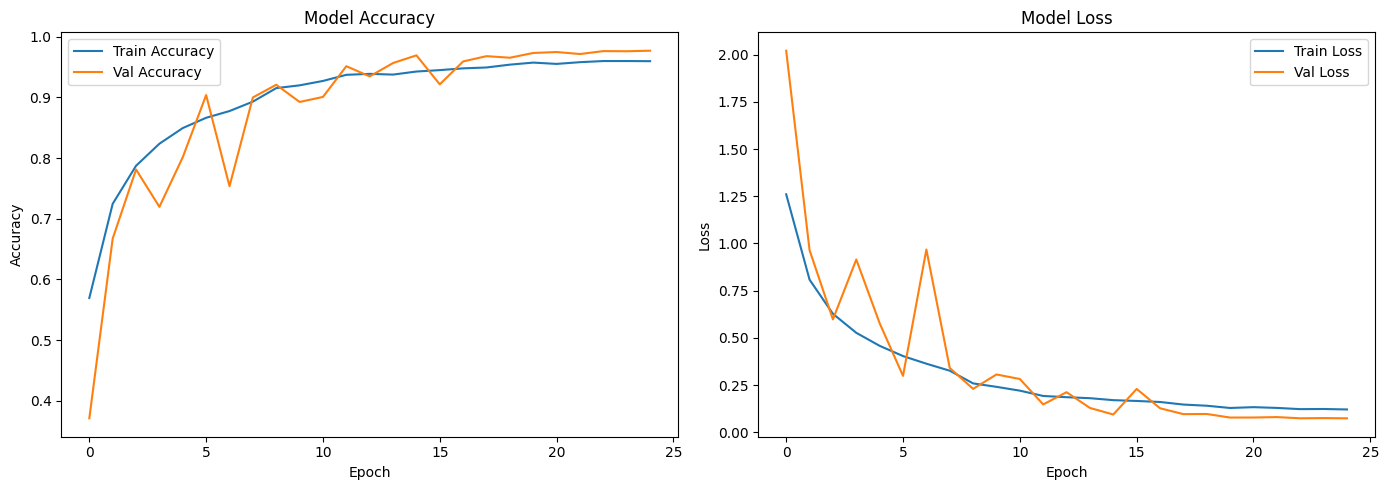

144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step

📊 Classification Report:

                                             precision    recall  f1-score   support

                      Tomato_Bacterial_spot       0.98      0.99      0.98       476
                        Tomato_Early_blight       0.96      0.96      0.96       445
                         Tomato_Late_blight       0.98      0.96      0.97       467
                           Tomato_Leaf_Mold       0.99      0.99      0.99       447
                  Tomato_Septoria_leaf_spot       0.97      0.98      0.97       468
Tomato_Spider_mites_Two_spotted_spider_mite       0.96      0.98      0.97       467
                        Tomato__Target_Spot       0.97      0.97      0.97       461
      Tomato__Tomato_YellowLeaf__Curl_Virus       0.99      0.98      0.99       482
                Tomato__Tomato_mosaic_virus       1.00      1.00      1.00       427
                             Tomato_healthy       1.00      0.99      1.00      

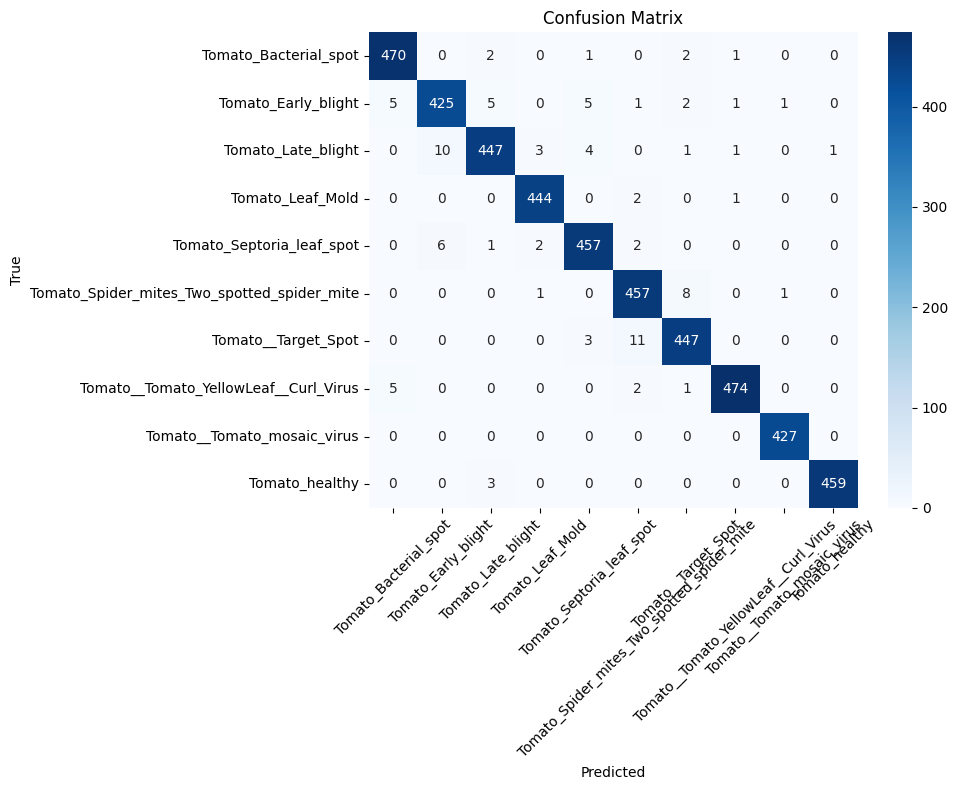

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Extract best params
best_lr = best_params[0]
best_dense = int(best_params[1])
best_dropout = best_params[2]

# Rebuild and train the model
final_model = build_cnn_model(
    lr=best_lr,
    dense_units=best_dense,
    dropout_rate=best_dropout
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

history = final_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# ✅ Save model
final_model.save("woa_optimized_model.keras")

# 🎯 Evaluate on test data
test_loss, test_acc = final_model.evaluate(test_gen, verbose=1)
print(f"\n🎯 Final Test Accuracy after WOA: {test_acc * 100:.2f}%")

# 📈 Plot training/validation accuracy & loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# 🧠 Classification report and confusion matrix
y_pred = final_model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# Classification report
print("\n📊 Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()